# Per Region Mechanisms

In this tutorial, we will use the list of MNV in 15,708 genomes from gnomAD dataset, combined with different genomic functional annotations such as intron/promoter/enhancer from [Finucane et al. 2015](https://www.nature.com/articles/ng.3404) to explore the mechanisms of MNV for different genomic regions.

## Density of MNV

In order to compare across different regions, we will define and calculate the density of MNV.
The density of MNV is defined as $\frac{N(WX\rightarrow YZ \mid I)}{N(WX \mid I)}$ for each region $I$ and MNV pattern $WX\rightarrow YZ$.
(e.g. If your MNV density of $WX\rightarrow YZ$ is twice higher in intron region compared to 5'UTR, this means that, given a sequence context of $WX$, there is 2 times higher chance of observing $WX\rightarrow YZ$ in intron region, compared to 5'UTR).

Here we will use pre-calculated density of MNV (pre-calculated using MNV data we provide in http://gnomad.broadinstitute.org/downloads, hg19 reference sequence, bed files defining the regions from  Finucane et al. 2015.):

In [1]:
import hail as hl
import hail.expr.aggregators as agg

In [10]:
#pre-calculated MNV density
#scaled so that the overall MNV density = 1
import numpy as np
import pandas as pd
m = ("gs://gnomad-qingbowang/MNV/wholegenome/mnv_density_relative_d1.tsv")
with hl.hadoop_open(m, 'r') as f:
        dst = pd.read_csv(f, sep="\t")
# due to technical artifact we were missing the index, so getting it back
m = ("gs://gnomad-public/release/2.1/mnv/resources/rownames_78.tsv")
with hl.hadoop_open(m, 'r') as f:
        rn = pd.read_csv(f, sep="\t") #row names
dst.index = np.array(rn.iloc[:,0])
display(dst.head())


,Coding_UCSC,DHS_Trynka,Enhancer_Hoffman,H3K27ac_PGC2,H3K4me1_Trynka,H3K4me3_Trynka,H3K9ac_Trynka,Intron_UCSC,TSS_Hoffman,Promoter_UCSC,Transcribed_Hoffman,UTR_3_UCSC,UTR_5_UCSC,TFBS_ENCODE
AA->CC,0.81135,0.69425,1.07040,1.05590,0.91856,0.96122,0.98173,1.04170,1.3986,1.3301,1.11190,0.90502,0.77072,0.98011
AA->CG,0.81139,0.90988,0.95276,0.99530,0.89083,1.00540,0.99129,0.95028,1.2717,1.0492,0.97497,0.82249,0.00000,0.99248
AA->CT,0.85133,0.98542,0.99943,0.98575,0.96159,1.02520,0.99434,0.97575,1.2165,1.0800,0.99143,0.88528,0.77592,1.00560
AA->GC,1.86800,1.09880,1.42960,1.20920,1.10990,1.39470,1.47900,1.08530,2.4321,1.8937,1.16270,1.74560,0.00000,1.26360
AA->GG,0.85327,0.85962,0.97928,1.05230,0.93301,1.00650,1.06260,0.99838,1.3590,1.2963,1.01830,0.91439,0.97173,0.99970


## Methylation rate

Now our aim is to understand the difference of MNV density.
As a first step, we will investigate the methylation rate of different regions in the genome, 
pre-calculated using hail aggregation function:

In [11]:
#pre-calculated methylation rate
import pandas as pd
m = "gs://gnomad-qingbowang/MNV/agg_stats/met_score_final.tsv"
with hl.hadoop_open(m, 'r') as f:
        met = pd.read_csv(f,sep="\t")
#get back the category names, index etc, and reorder to let them match
# (again due to technical artifact, we are missing the row indices in the file, so will just hard code them for here)
# (see the source code to replicate this from the beginning)
idx_met = ['Coding_UCSC', 'DHS_Trynka', 'Enhancer_Hoffman', 'H3K4me1_Trynka',
       'H3K4me3_Trynka', 'H3K9ac_Trynka', 'Intron_UCSC', 'TSS_Hoffman',
       'Promoter_UCSC', 'Transcribed_Hoffman', 'UTR_3_UCSC', 'UTR_5_UCSC',
       'TFBS_ENCODE', 'H3K27ac_PGC2', 'all'] #index for the methylation file
categ = ["Coding_UCSC", "DHS_Trynka", "Enhancer_Hoffman", "H3K27ac_PGC2", "H3K4me1_Trynka", "H3K4me3_Trynka", "H3K9ac_Trynka", "Intron_UCSC", "TSS_Hoffman",
        "Promoter_UCSC", "Transcribed_Hoffman", "UTR_3_UCSC", "UTR_5_UCSC", "TFBS_ENCODE"] #re-order to match downstream analysis
met.index = idx_met    
met = met.loc[categ]        
display(met)

,mean,stdev,min,max,n,sum
Coding_UCSC,0.58399,0.40716,0.0,1.0,3351791,1957400.0
DHS_Trynka,0.54357,0.35733,0.0,1.0,13147101,7146400.0
Enhancer_Hoffman,0.44760,0.36685,0.0,1.0,4819123,2157000.0
H3K27ac_PGC2,0.66391,0.34360,0.0,1.0,20563094,13652000.0
H3K4me1_Trynka,0.71686,0.30569,0.0,1.0,29660461,21262000.0
H3K4me3_Trynka,0.53282,0.37411,0.0,1.0,13876452,7393600.0
H3K9ac_Trynka,0.54652,0.37552,0.0,1.0,13841447,7564600.0
Intron_UCSC,0.79676,0.25110,0.0,1.0,23358396,18611000.0
TSS_Hoffman,0.19418,0.30103,0.0,1.0,4535055,880630.0
Promoter_UCSC,0.43763,0.40903,0.0,1.0,4401542,1926200.0


And we can plot it to see the correlation with the density of MNV:
(Focusing on the specific classes of MNV patterns, as in the manuscript)

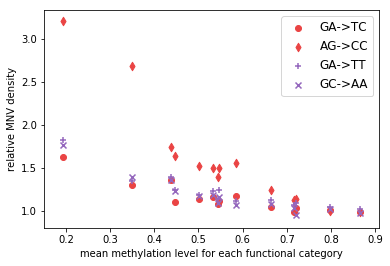

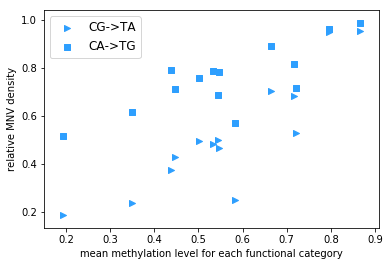

In [12]:
#vs CpG methylation rate
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

col_dict={"CpG_Ti":"#2E9FFEff","Ti":"#2ca02cff","Tv":"#EA4444FF","rep":"#8c564bFF","polzeta":"#9467bdFF","others":"#888888ff"}
#colors corresponding to the rest of the analysis
#selecting the ones that are most relevant to the rest of the analysis
rows1 = ["GA->TC","AG->CC","GA->TT","GC->AA"]
rows2 = ["CG->TA","CA->TG"]
classes1 = ["Tv","Tv","polzeta","polzeta"]
classes2 = ["CpG_Ti","CpG_Ti"]
cols1 = []
cols2 = []
for c in classes1:
    cols1.append(col_dict[c]) #prepared the color
for c in classes2:
    cols2.append(col_dict[c]) #prepared the color
toplot1 = dst.loc[rows1,:]
toplot2 = dst.loc[rows2,:]
mk1 = ["o","d","+","x"] #prepare different markers
mk2 = [">","s"]
for i in range(toplot1.shape[0]):
    plt.scatter(met["mean"],toplot1.iloc[i,:], 
                color=cols1[i], marker=mk1[i])
plt.xlabel("mean methylation level for each functional category")
plt.ylabel("relative MNV density")
plt.legend(prop={'family':"Microsoft Sans Serif", "size":12})
plt.show()
for i in range(toplot2.shape[0]):
    plt.scatter(met["mean"],toplot2.iloc[i,:],
                color=cols2[i], marker=mk2[i])
plt.xlabel("mean methylation level for each functional category")
plt.ylabel("relative MNV density")
plt.legend(prop={'family':"Microsoft Sans Serif", "size":12})
plt.show()

In the manuscript we simple ranked the methylation level, instead of actually showing the mean score (Fig 4 b, c):
(Which does not change the overall discussion)
(Also, we have removed Coding in the analysis, to avoid the strong selection effect on LoF variants specifically)

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Microsoft Sans Serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Microsoft Sans Serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Microsoft Sans Serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


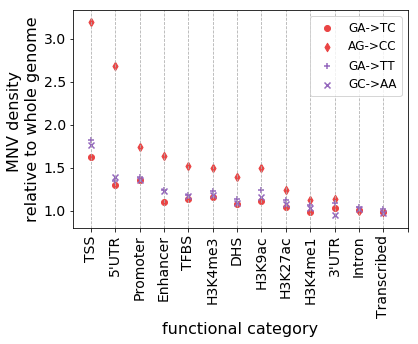

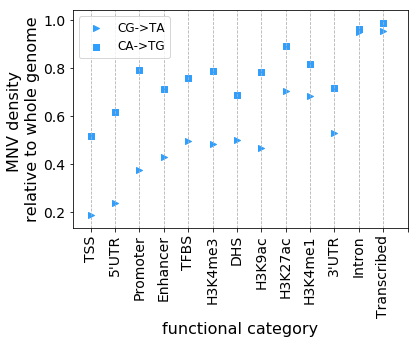

In [7]:
#exclude the "Coding" from the categories 
toplot1.drop("Coding_UCSC",axis=1, inplace=True)
toplot2.drop("Coding_UCSC",axis=1, inplace=True)
met.drop("Coding_UCSC", inplace=True)

#rank the methylation status
met["rank"] = 0
j=0
for i in np.argsort(met["mean"]):
    met.loc[met.index[i],"rank"] = j
    j += 1

#and plot again    
categnames = ["TSS","5'UTR","Promoter","Enhancer","TFBS","H3K4me3","DHS","H3K9ac","H3K27ac","H3K4me1","3'UTR","Intron","Transcribed"]
for i in range(toplot1.shape[0]):
    plt.scatter(met["rank"],toplot1.iloc[i,:],
                color=cols1[i], marker=mk1[i], label=toplot1.index[i])
    plt.xticks(range(14),categnames, rotation=90, fontname = "Microsoft Sans Serif", size=14)
    plt.yticks(fontname = "Microsoft Sans Serif", size=14)
    plt.grid(b=True, axis="x",linestyle='--')
    plt.ylabel("MNV density \nrelative to whole genome", fontname="Microsoft Sans Serif", size=16)
    plt.xlabel("functional category", fontname="Microsoft Sans Serif", size=16)
    plt.legend(prop={'family':"Microsoft Sans Serif", "size":12})
plt.show()
for i in range(toplot2.shape[0]):
    plt.scatter(met["rank"],toplot2.iloc[i,:],
                color=cols2[i], marker=mk2[i], label=toplot2.index[i])
    plt.xticks(range(14),categnames, rotation=90, fontname = "Microsoft Sans Serif", size=14)
    plt.yticks(fontname = "Microsoft Sans Serif", size=14)
    plt.grid(b=True, axis="x",linestyle='--')
    plt.ylabel("MNV density \nrelative to whole genome", fontname="Microsoft Sans Serif", size=16)
    plt.xlabel("functional category", fontname="Microsoft Sans Serif", size=16)
    plt.grid(b=True, axis="x",linestyle='--')
    plt.legend(prop={'family':"Microsoft Sans Serif", "size":12})
plt.show()

In [13]:
#also the correlation (of the raw methylation score vs MNV density)
from scipy import stats
for i in range(toplot1.shape[0]):
    print (toplot1.index[i])
    print (stats.pearsonr(met["mean"],toplot1.iloc[i,:]))
for i in range(toplot2.shape[0]):
    print (toplot2.index[i])
    print (stats.pearsonr(met["mean"],toplot2.iloc[i,:]))

GA->TC
(-0.8779037145216885, 3.658288196621447e-05)
AG->CC
(-0.9100920755672778, 6.267588221395356e-06)
GA->TT
(-0.8860449529599788, 2.4626737827245967e-05)
GC->AA
(-0.9152764485063938, 4.4394870783988385e-06)
CG->TA
(0.8760697273683588, 3.984142259060211e-05)
CA->TG
(0.7829419118677354, 0.0009287396001809867)


## Fraction of MNVs of different origin across genome

In the analysis above we saw that some of the density MNV classes have strong correlation with the local methylation rate. 
However we have not explored the base line MNV frequency (not the density).
In this section we will compare the frequency of MNV, by naively estimating the fraction of MNVs per origin.

This is simply done by 2 steps:
1. For some of the MNV pattern that are known to be enriched for specific mechanism, we assign origin/mechanism category (As we have done so far. e.g. CG->TA is "CpG transition") category, and GA->TT is "pol zeta" category
2. For each functional annotation, we calculate the fraction of MNVs in each category, simply by dividing by the total number of MNVs in that category

First we will get back to the count matrix calculated for each functional category, and summarize it in a dataframe:

In [26]:
#categories, ordered by genomic coordinates
categ_ordered = ["Enhancer_Hoffman", "Promoter_UCSC", "TSS_Hoffman", "UTR_5_UCSC", "Coding_UCSC","Intron_UCSC","UTR_3_UCSC"]
categnames_ordered = ["Enhancer", "Promoter", "TSS", "5'UTR", "Coding","Intron""3'UTR"]
#MNV patterns known to be enriched for specific mechanism
CpG = ["GA->AG","CC->TT","AC->GT","CA->TG"]
polzeta = ["GA->TT","GC->AA"]
rep = ["AC->CA","CA->AC","AT->TA","TA->AT","AA->TT","AA->CC"]
Tv = ["TA->CG","CG->AT","AT->CG","CG->GC","GC->CG","CG->AC"]

#index for count matrix, missing due to hard-coding
idx_refs = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT',
       'TA', 'TC', 'TG', 'TT']


#get the count matrix
for c in categ_ordered:
    m = "gs://gnomad-qingbowang/MNV/wholegenome/cnt_mat_d1_{0}.tsv".format(c)
    with hl.hadoop_open(m, 'r') as f:
        mat = pd.read_csv(f,sep="\t") #case cnts
    mat.fillna(0, inplace=True)
    mat.index = mat.columns
    mat = collapse_crstb_to_revcomp(mat)
    mat.index = mat.refs + "->" + mat.alts
    if c ==categ_ordered[0]:
        df = mat
        df.cnt = df.cnt
        del df["refs"]
        del df["alts"]
        df.columns = [c]
    else: 
        df[c] = mat["cnt"]

In [28]:
display(df.head())

,Enhancer_Hoffman,Promoter_UCSC,TSS_Hoffman,UTR_5_UCSC,Coding_UCSC,Intron_UCSC,UTR_3_UCSC
AA->CC,274.0,256.0,125.0,27.0,96.0,2919.0,85.0
AA->CG,221.0,183.0,103.0,0.0,87.0,2413.0,70.0
AA->CT,160.0,130.0,68.0,17.0,63.0,1710.0,52.0
AA->GC,500.0,498.0,297.0,0.0,302.0,4155.0,224.0
AA->GG,648.0,645.0,314.0,88.0,261.0,7232.0,222.0


And we can plot it by simply normalizing by the column sum (Fig 4 d):

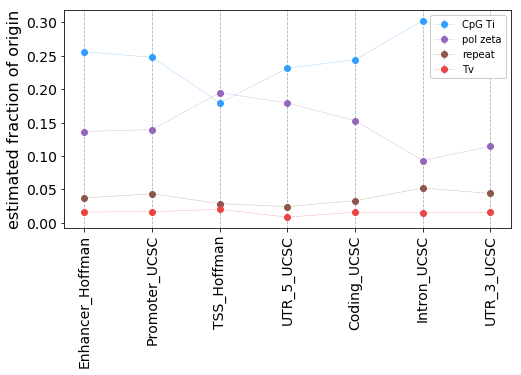

In [31]:
#select specific ones of interest, and normalize
v_cpg = df.loc[CpG,:].sum(axis=0) / df.sum(axis=0)
v_polzeta = df.loc[polzeta,:].sum(axis=0) / df.sum(axis=0)
v_rep = df.loc[rep,:].sum(axis=0) / df.sum(axis=0)
v_Tv = df.loc[Tv,:].sum(axis=0) / df.sum(axis=0)
#make it a dataframe, and add error bars (which turns out to be negligible compared to the size of dots)
df2 = pd.DataFrame([v_cpg, v_polzeta, v_rep, v_Tv])
df2.index = ["CpG","polzeta","rep","Tv"]
s = df.sum(axis=0)
df2_err = df2.apply(lambda x: np.sqrt(x*(1-x)/s), axis=1)

#and plot
cols=["#2E9FFEFF","#9467bdff","#8c564bFF","#EA4444ff"]
labs=["CpG Ti","pol zeta","repeat","Tv"]
x = [1,2,3,4,5,6,7]
plt.figure(figsize=(8,4))
for i in range(df2.shape[0]):
    plt.errorbar(x,df2.iloc[i,:], yerr = df2_err.iloc[i,:],
                 fmt='o:',color=cols[i], label = labs[i], linewidth=0.5)
plt.xticks(x, df2.columns.values, fontname="Microsoft Sans Serif", rotation=90, size=14)
plt.yticks(fontname = "Microsoft Sans Serif", size=14)
plt.ylabel("estimated fraction of origin", fontname="Microsoft Sans Serif", size=16)
plt.legend(framealpha=1)
plt.grid(b=True, axis="x",linestyle='--')
plt.show()


As we can see, CpG transition and polymerase zeta signature basically dominates the MNV signals. 
(It is cool that we still see the difference specifically around TSS, and also that we can still see the correlation of Transversions with methylation level, although the fraction of such MNVs are very low as shown above.)

Finally, as we did in the previous tutorial ([global_mechanisms.ipynb](https://github.com/macarthur-lab/gnomad_mnv/blob/master/tutorials/global_mechanisms.ipynb)), we can do this type of analysis for MNVs of distance>1.
(In the example below, we will do it only for d=1,2, and 10 to save the space)
(note that for some of the categories, the number of MNV for a single category could be relatively low, increasing the noise ratio.
We are not doing statistical tests for each of the cell here.)

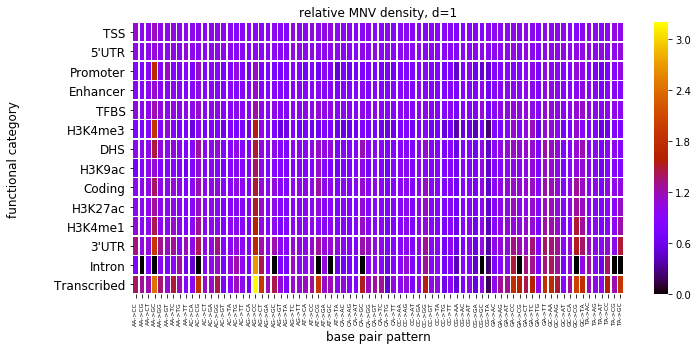

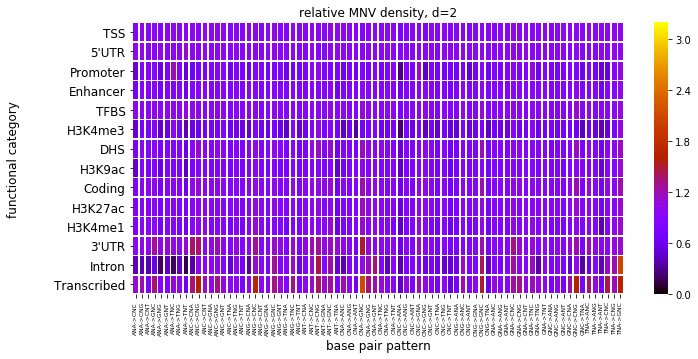

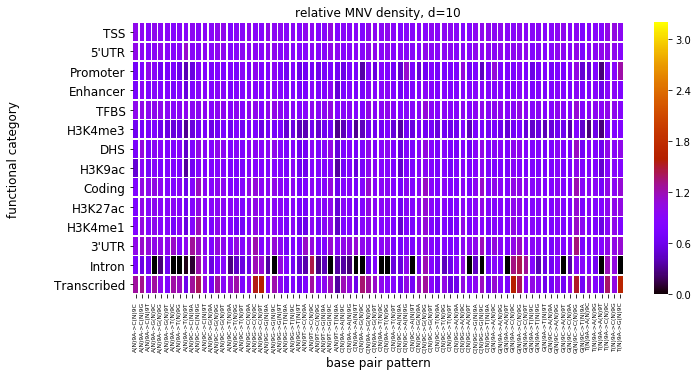

In [35]:
#prepare short alias for category names, just to save some space
categnames_real = ['TSS_Hoffman', 'UTR_5_UCSC', 'Promoter_UCSC', 'Enhancer_Hoffman',
       'TFBS_ENCODE', 'H3K4me3_Trynka', 'DHS_Trynka', 'H3K9ac_Trynka',
       'Coding_UCSC', 'H3K27ac_PGC2', 'H3K4me1_Trynka', 'UTR_3_UCSC',
       'Intron_UCSC', 'Transcribed_Hoffman']
categnames = ["TSS","5'UTR","Promoter","Enhancer","TFBS","H3K4me3","DHS","H3K9ac","Coding","H3K27ac","H3K4me1","3'UTR","Intron","Transcribed"]
ix = df.index #just to restore the index

for d in [1,2,10]: #range(1,10) if you want to do all 1..10
    m = ("gs://gnomad-qingbowang/MNV/wholegenome/mnv_density_relative_d{0}.tsv".format(d))
    with hl.hadoop_open(m, 'r') as f:
            dst = pd.read_csv(f, sep="\t")
    dst = dst[categnames_real[::-1]]
    dst.index = ix.str[0]+"N"*(d-1)+ix.str[1:-1]+"N"*(d-1)+ix.str[-1]
    if d==1: M=dst.max().max() #keep the scale constant 
    fig, ax = plt.subplots()
    fig.set_size_inches(11,5)
    ax = sns.heatmap(dst.transpose() , vmin=0, vmax=M, xticklabels=True,
                     linewidths=.5, annot=False, cmap="gnuplot")
    if d > 2:
        xtk = ix.str[0] + "(N)" + str(d-1) + ix.str[1:-1] + "(N)" + str(d-1) + ix.str[-1]
    else:
        xtk = ax.get_xticklabels()
    ax.set_title("relative MNV density, d={0}".format(d), fontname = "Microsoft Sans Serif", size=12)
    ax.set_yticklabels(categnames, rotation=0, fontname = "Microsoft Sans Serif", size=12)
    ax.set_xticklabels(xtk, rotation=90, fontname = "Microsoft Sans Serif", size=6)
    ax.set_ylabel("functional category\n\n", fontname = "Microsoft Sans Serif", size=12)
    ax.set_xlabel("base pair pattern", fontname = "Microsoft Sans Serif", size=12)
    plt.show()



## End notes

In this tutorial, we will use the list of MNV in 15,708 genomes from gnomAD dataset, combined with different genomic functional annotations such as intron/promoter/enhancer from Finucane et al. 2015 to explore the mechanisms of MNV for different genomic regions.

Overall throughout the 6 tutorials we have explored the distribution, functional impacts and mechanisms of MNVs.
The list of MNVs are available in our [download page](http://gnomad.broadinstitute.org/downloads), and also MNVs in the coding region within single codons are viewable in the browser (e.g. gnomad.broadinstitute.org/variant/9-38577187-GA-AG ). 

Also please read the [manuscript](https://www.biorxiv.org/content/10.1101/573378v2) for more discussions on what we have discovered in the tutorial.

We hope users enjoy the biology underlying the MNVs, and use the information for accurate functional interpretation of MNVs.
Please let us know for any question/concern. Thanks for reading this tutorial!

In [16]:
#functions
idx_refs = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT',
       'TA', 'TC', 'TG', 'TT']

comp = {}
comp["A"] = "T"
comp["T"] = "A"
comp["G"] = "C"
comp["C"] = "G"
comp["N"] = "N"

def revcomp(seq):
    out = ""
    for i in seq[::-1]:
        out = out + comp[i]
    return (out)

def collapse_crstb_to_revcomp(crstb):
    # collaspse to a table, instead of another matrix
    flt = crstb.stack().reset_index()
    flt.columns = ['refs', 'alts', 'cnt']
    for i in range(flt.shape[0]):
        if i in flt.index:  # if it hasn't been deleted yet
            refs_revcomp = revcomp(flt.refs[i])
            alts_revcomp = revcomp(flt.alts[i])
            ix_revcomp = flt[(flt.refs == refs_revcomp) & (flt.alts == alts_revcomp)].index[0]
            if i != ix_revcomp:  # if revcomp is not yourself
                flt.loc[i, "cnt"] = flt.loc[i, "cnt"] + flt.loc[ix_revcomp, "cnt"]
                flt = flt.drop(ix_revcomp)
    flt = flt[(flt.refs.str[0]!=flt.alts.str[0])&(flt.refs.str[1]!=flt.alts.str[1])]  # deleting trivial ones
    flt.reset_index(inplace=True)
    del flt["index"]
    return (flt)

#also collapse the reference counts
def collapse_ref_cnts(ref_cnt_matrix):
    bp = ref_cnt_matrix.index
    for i in bp: #for all the 2bp
        if i in ref_cnt_matrix.index: #if hasn't been deleted yet
            i_revcomp = revcomp(i)
            if i != i_revcomp:  # if revcomp is not yourself
                ref_cnt_matrix.loc[i, :] = ref_cnt_matrix.loc[i, :] + ref_cnt_matrix.loc[i_revcomp, :]
                ref_cnt_matrix = ref_cnt_matrix.drop(i_revcomp)
    return (ref_cnt_matrix)
